In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter

from load_wastewater_data import load_systems_data

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [132]:
plot_path = f"../plots/wastewater_model/normalization_strategies/flow_rates"
os.makedirs(os.path.join(plot_path), exist_ok=True)
# file_name_prefix = f"{substance}_{rain_scenario}_{degradation_setting}"

In [133]:
# define experiment to be preprocessed
experiment_series = "2024_09_06"

substance = "COVID_1min_substance_resolution" # one of PMMoV, COVID
rain_scenario = "MittelstarkerRegen" # one of Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [134]:
# Load Data

# for flow normalization
df_KeinRegen = load_systems_data(experiment_series, substance, "KeinRegen", degradation_setting, file_type="concentrations") 
df_KeinRegen_flow_rates = load_systems_data(experiment_series, substance, "KeinRegen", degradation_setting, file_type="flow_rates")

# measurements
df_Rain = load_systems_data(experiment_series, substance, rain_scenario, degradation_setting, file_type="concentrations") 
df_Rain_flow_rates = load_systems_data(experiment_series, substance, rain_scenario, degradation_setting, file_type="flow_rates") 

### Normalisation with flow rates

copies/l normalized = (current flow rate) / (median flow rate) * (copies/l of RNA)

source: https://www.umweltbundesamt.de/sites/default/files/medien/1/dokumente/amelag-leitfaden-4.pdf

median flow rate represents the estimate of "Trockenwetterzufluss", but we actually now the Trockenwetterzufluss, so we can take the mean values of these...

The median is calculated per sampling point and memilio id based on KeinRegen scenario values

In [135]:
#subselect specific sampling point
sampling_point = "16"

df_flow_rates = df_Rain_flow_rates.loc[df_Rain_flow_rates.sampling_point==sampling_point, :].copy()
df_flow_rates_no_rain = df_KeinRegen_flow_rates.loc[df_KeinRegen_flow_rates.sampling_point==sampling_point, :].copy()

df_concentration = df_Rain.loc[df_Rain.sampling_point==sampling_point, :].copy()
df_concentration_no_rain = df_KeinRegen.loc[df_KeinRegen.sampling_point==sampling_point, :].copy()

In [136]:
# DYNA only collects changes in flow rates if necessary, so we need to fill with the last value
df_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").resample("1min", include_groups=False).ffill().reset_index()
df_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").resample("1min", include_groups=False).ffill().reset_index()

In [137]:
df_concentration.head()

,minutes,copies/l,temperature,sampling_point,memilio_id,time,time_in_days
607125,1,0.00000,0.0,16,5,2024-01-01 00:01:00,0.00000
607126,10,0.00000,0.0,16,5,2024-01-01 00:10:00,0.00625
607127,100,0.00000,0.0,16,5,2024-01-01 01:40:00,0.06875
607128,1000,0.00000,0.0,16,5,2024-01-01 16:40:00,0.69375
607129,10000,23.53983,0.0,16,5,2024-01-07 22:40:00,6.94375


#### Basic plots to get a feeling for the data

/tmp/ipykernel_239627/2527125076.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


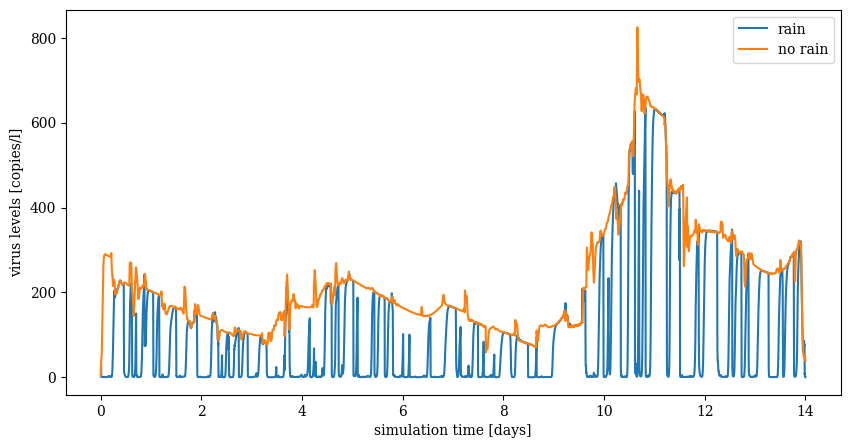

In [138]:
def compare_measurements_of_rain_scenarios(df_concentration, df_concentration_no_rain, memilio_id):
    """
    Create a plot with two curves, one for the concentration of the virus in the rain scenario and one for the concentration in the no rain scenario.
    """
    date_form = DateFormatter("%-d")
    df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
    df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
    df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
    df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

    df_concentration_sub.sort_values("time", inplace=True)
    df_flow_rates_sub.sort_values("time", inplace=True)
    df_flow_rates_no_rain_sub.sort_values("time", inplace=True)
    df_concentration_no_rain_sub.sort_values("time", inplace=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(df_concentration_sub.time, df_concentration_sub["copies/l"], label="rain")
    plt.plot(df_concentration_no_rain_sub.time, df_concentration_no_rain_sub["copies/l"], label="no rain")
    ax.xaxis.set_major_formatter(date_form) 
    ax.set_xlabel(f"simulation time [days]") # , fontsize=15
    ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    ax.set_ylabel(f"virus levels [copies/l]") # , fontsize=15
    plt.legend()
    plt.close()
    return fig

compare_measurements_of_rain_scenarios(df_concentration, df_concentration_no_rain, 1)

In [139]:
memilio_id = 1

/tmp/ipykernel_239627/1272218366.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/1272218366.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/1272218366.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/1272218366.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/1272218366.py:49: UserWarn

205.79836941175608
-661.6405610236905


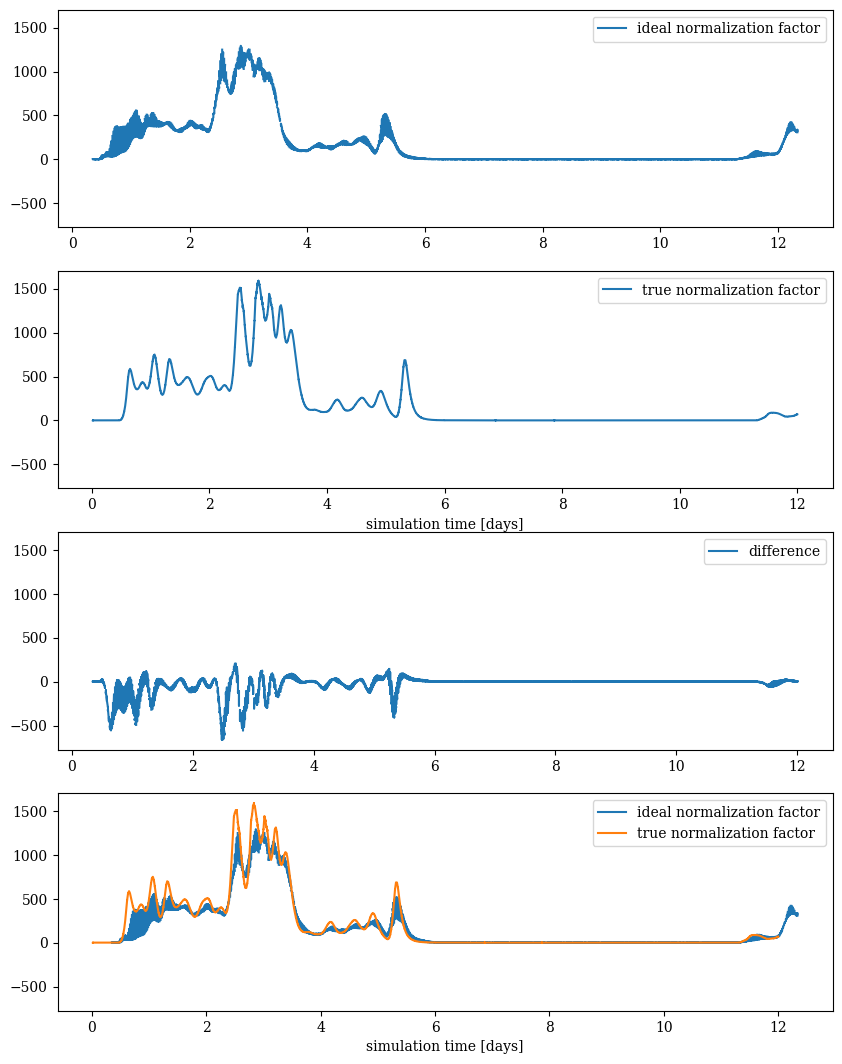

In [140]:
date_form = DateFormatter("%-d")

df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

df_concentration_sub = df_concentration.loc[df_concentration.time<=pd.Timestamp("2024-01-01 12:00:00"), :].copy()
df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.time<=pd.Timestamp("2024-01-01 12:00:00"), :].copy()
df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.time<=pd.Timestamp("2024-01-01 12:00:00"), :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.time<=pd.Timestamp("2024-01-01 12:00:00"), :].copy()


df_concentration_sub.sort_values("time", inplace=True)
df_flow_rates_sub.sort_values("time", inplace=True)
df_flow_rates_no_rain_sub.sort_values("time", inplace=True)
df_concentration_no_rain_sub.sort_values("time", inplace=True)

timedelta = pd.Timedelta("-20min")
df_concentration_sub["time"] = df_concentration_sub["time"] - timedelta
df_concentration_no_rain_sub["time"] = df_concentration_no_rain_sub["time"] - timedelta

df_concentration_sub["ideal_normalization"] = df_concentration_no_rain_sub["copies/l"]/ df_concentration_sub["copies/l"]
df_flow_rates_sub["true_normalization"] = df_flow_rates_sub["l/s"] /  np.mean(df_flow_rates_no_rain_sub["l/s"])

fig, axs = plt.subplots(nrows=4, figsize=(10, 13), sharey=True)
axs[0].plot(df_concentration_sub.time, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
axs[1].plot(df_flow_rates_sub.time, df_flow_rates_sub["true_normalization"], label="true normalization factor")
axs[0].xaxis.set_major_formatter(date_form) 
axs[0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
axs[1].xaxis.set_major_formatter(date_form) 
axs[1].set_xlabel(f"simulation time [days]") # , fontsize=15
axs[1].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
axs[0].legend()
axs[1].legend()

axs[3].plot(df_concentration_sub.time, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
axs[3].plot(df_flow_rates_sub.time, df_flow_rates_sub["true_normalization"], label="true normalization factor")
axs[3].xaxis.set_major_formatter(date_form) 
axs[3].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
axs[3].xaxis.set_major_formatter(date_form) 
axs[3].set_xlabel(f"simulation time [days]") # , fontsize=15
axs[3].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
axs[3].legend()

df_combined = pd.merge(df_concentration_sub, df_flow_rates_sub, on="time")
axs[2].plot(df_combined.time, df_combined["ideal_normalization"]-df_combined["true_normalization"], label="difference")
axs[2].xaxis.set_major_formatter(date_form) 
axs[2].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
axs[2].legend()
# plt.close()

print((df_combined["ideal_normalization"]-df_combined["true_normalization"]).max())
print((df_combined["ideal_normalization"]-df_combined["true_normalization"]).min())

/tmp/ipykernel_239627/3452815233.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/3452815233.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/3452815233.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


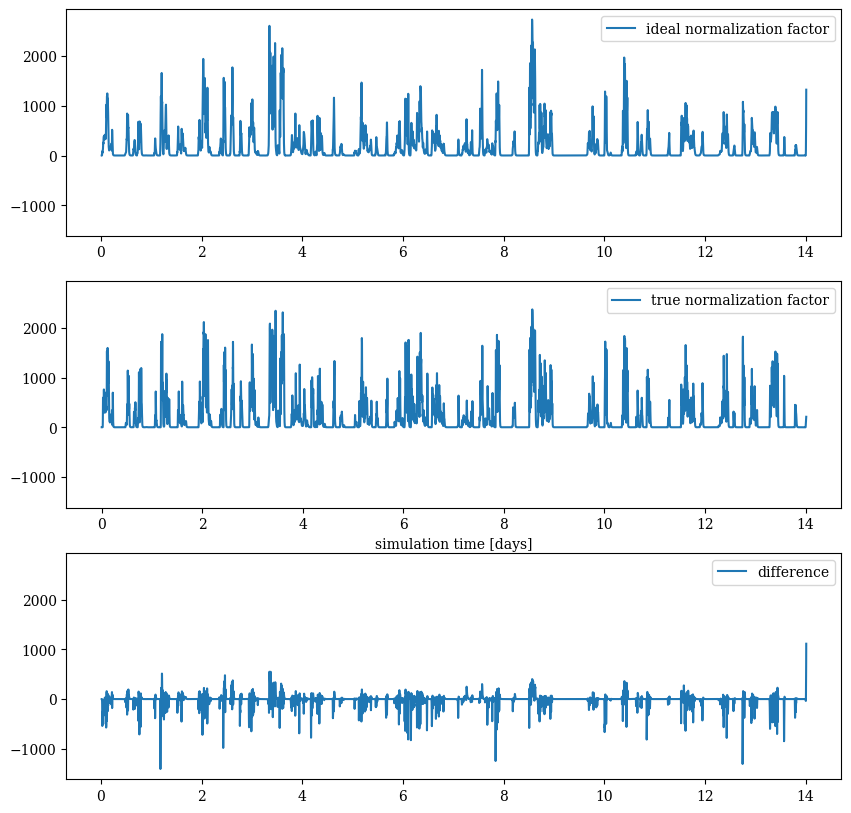

In [141]:
def compare_ideal_with_true_normalization_factors(df_concentration, df_concentration_no_rain, df_flow_rates, df_flow_rates_no_rain, memilio_id):
    """
    Create a plot with two curves, one for the concentration of the virus in the rain scenario and one for the concentration in the no rain scenario.
    """
    date_form = DateFormatter("%-d")
    df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
    df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
    df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
    df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

    df_concentration_sub.sort_values("time", inplace=True)
    df_flow_rates_sub.sort_values("time", inplace=True)
    df_flow_rates_no_rain_sub.sort_values("time", inplace=True)
    df_concentration_no_rain_sub.sort_values("time", inplace=True)

    timedelta = pd.Timedelta("-20min")
    df_concentration_sub["time"] = df_concentration_sub["time"] - timedelta
    df_concentration_no_rain_sub["time"] = df_concentration_no_rain_sub["time"] - timedelta

    df_concentration_sub["ideal_normalization"] = df_concentration_no_rain_sub["copies/l"]/ df_concentration_sub["copies/l"]
    df_flow_rates_sub["true_normalization"] = df_flow_rates_sub["l/s"] /  np.mean(df_flow_rates_no_rain_sub["l/s"])

    fig, axs = plt.subplots(nrows=3, figsize=(10, 10), sharey=True)
    axs[0].plot(df_concentration_sub.time, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
    axs[1].plot(df_flow_rates_sub.time, df_flow_rates_sub["true_normalization"], label="true normalization factor")
    axs[0].xaxis.set_major_formatter(date_form) 
    axs[0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[1].xaxis.set_major_formatter(date_form) 
    axs[1].set_xlabel(f"simulation time [days]") # , fontsize=15
    axs[1].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[0].legend()
    axs[1].legend()
    df_combined = pd.merge(df_concentration_sub, df_flow_rates_sub, on="time")
    axs[2].plot(df_combined.time, df_combined["ideal_normalization"]-df_combined["true_normalization"], label="difference")
    axs[2].xaxis.set_major_formatter(date_form) 
    axs[2].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[2].legend()
    plt.close()
    return fig

compare_ideal_with_true_normalization_factors(df_concentration, df_concentration_no_rain, df_flow_rates, df_flow_rates_no_rain, 1)

/tmp/ipykernel_239627/2916488042.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


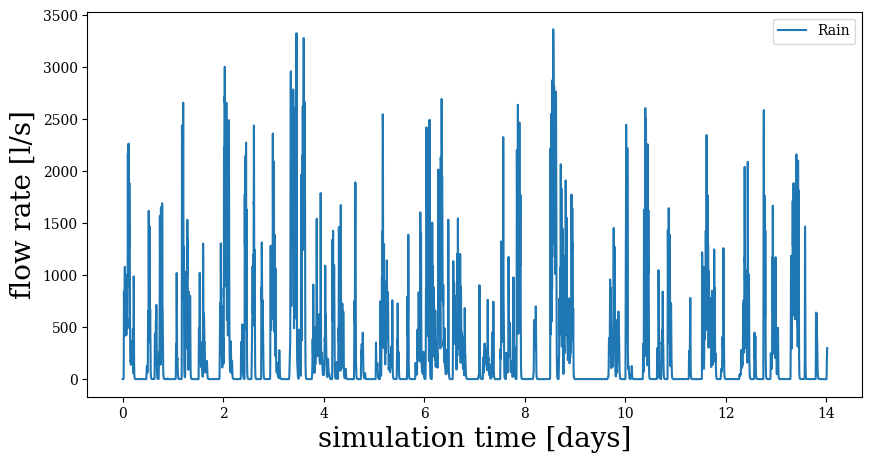

In [142]:
def visualize_flow_rates(df_flow_rates, simulation_id):
    date_form = DateFormatter("%-d")
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(df_flow_rates.loc[df_flow_rates.memilio_id==simulation_id,:], x="time", y="l/s", label="Rain", ax=ax)
    ax.xaxis.set_major_formatter(date_form) 
    ax.set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    ax.set_ylabel(f"flow rate [l/s]", fontsize=20) # , fontsize=15
    ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    # plt.ylim(0,0.5)
    return fig

fig = visualize_flow_rates(df_flow_rates, 1)

#### Aggregation and normalization of data

In [143]:
# aggregate flow rates data to time interval for which we have concentration data (NOTE: you might have to change this for future settings)
freq = "5min"

#df_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").resample(freq)["l/s"].mean().reset_index()
#df_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").resample(freq)["l/s"].mean().reset_index()
# aggregation of concentration data is not necessary
#df_concentration = df_concentration.set_index("time").groupby("memilio_id").resample(freq)["copies/l"].mean().reset_index()
#df_concentration_no_rain = df_concentration_no_rain.set_index("time").groupby("memilio_id").resample(freq)["copies/l"].mean().reset_index()


# potentially play around with rolling means to see whether this improves the normalization.
# in my experience, it does not
"""
rolling_window = "1.5h"
# rolling mean
df_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()
df_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()
"""
# possibility to use rolling means for concentration data
#df_concentration = df_concentration.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()
#df_concentration_no_rain = df_concentration_no_rain.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()

'\nrolling_window = "1.5h"\n# rolling mean\ndf_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()\ndf_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()\n'

In [144]:
# Another time shift seems to be more optimal?
timedelta = pd.Timedelta("-20min")
df_concentration["time"] = df_concentration["time"] - timedelta
df_concentration_no_rain["time"] = df_concentration_no_rain["time"] - timedelta

In [217]:
def simulate_sampling_strategies(df, measure_col="copies/l"):
    df.time = pd.to_datetime(df.time)
    df["day"]= [el.day for el in df.time]
    df["hour"] = [el.hour for el in df.time]

    # resample every 1 minutes and fill with the last available value
    resampled_df = df.set_index("time").groupby(["memilio_id"]).resample("1min").ffill()[[measure_col, 'day', 'hour']].reset_index()
    # get hourly measurements
    resampled_df = resampled_df.loc[(resampled_df.time.dt.minute).mod(60) == 0,:]
    # calculate 24h samples
    df_24h = resampled_df.groupby(["memilio_id", "day"]).mean().reset_index().rename(columns={measure_col: "24h_sample"})

    # only consider 24h samples with 24h of data
    df_24h = df_24h.loc[df_24h.hour==11.5, ["day", "memilio_id", "24h_sample"]]

    # extract morning sample column
    df_morning_sample = resampled_df.loc[resampled_df.hour==10,:].rename(columns={measure_col: "morning_sample"}).loc[:,  ["day", "memilio_id", "morning_sample"]]
    # combine everything
    df_measurements = pd.merge(resampled_df, pd.merge(df_24h, df_morning_sample, on=["memilio_id", "day"], how="outer"), on=["memilio_id", "day"], how="inner")[["memilio_id", "24h_sample", "morning_sample", "day"]].drop_duplicates()
    return df_measurements

In [189]:
test = simulate_sampling_strategies(df_flow_rates, measure_col="l/s")
# plt.plot(test.loc[test.memilio_id==1, "time"], test.loc[test.memilio_id==1, "l/s"])
# plt.plot(test.loc[test.memilio_id==1, "time"], test.loc[test.memilio_id==1, "24h_sample"])

In [170]:
# get mean flow rates in no rain scenario
mean_values = df_flow_rates_no_rain.groupby(["memilio_id"])["l/s"].mean().reset_index().rename(columns={"l/s": "mean_l/s"})


In [218]:
df_concentration_agg = simulate_sampling_strategies(df_concentration, measure_col="copies/l")
df_flow_rates_agg = simulate_sampling_strategies(df_flow_rates, measure_col="l/s")
df_flow_rates_agg = pd.merge(df_flow_rates_agg, mean_values, on=["memilio_id"], how="left")

In [219]:
df_concentration_agg.head()

,memilio_id,24h_sample,morning_sample,day
0,1,NaN,223.30165,1
23,1,80.176788,136.22389,2
47,1,48.011752,23.71740,3
71,1,30.594129,0.07098,4
95,1,71.089565,18.01081,5


In [208]:
# normalize w.r.t. flow rates
normalization_factors = df_flow_rates_agg.loc[:,["day", "memilio_id"]].copy()
normalization_factors["flow_normalization_factor"] = df_flow_rates_agg["24h_sample"]/df_flow_rates_agg["mean_l/s"]

df_concentration_agg = pd.merge(df_concentration_agg.loc[:,["day", "memilio_id", "24h_sample"]], normalization_factors, on=["memilio_id", "day"], how="inner")
df_concentration_agg["flow_normalized_copies/l"] = df_concentration_agg["24h_sample"]*df_concentration_agg["flow_normalization_factor"]
df_concentration_agg.sort_values("day", inplace=True)
df_concentration_agg.rename(columns={"24h_sample": "copies/l"}, inplace=True)

In [209]:
df_concentration_agg

,day,memilio_id,copies/l,flow_normalization_factor,flow_normalized_copies/l
0,1,1,NaN,NaN,NaN
14,1,2,NaN,NaN,NaN
28,1,3,NaN,NaN,NaN
42,1,4,NaN,NaN,NaN
56,1,5,NaN,NaN,NaN
...,...,...,...,...,...
41,14,3,544.871627,145.929632,79512.916234
13,14,1,138.546034,154.805265,21447.655529
27,14,2,184.010427,152.828502,28122.038071
55,14,4,244.484971,149.051885,36440.945940


In [214]:
df_concentration_agg["time"] = pd.Timestamp("2024-01-01 11:30:00") + pd.TimedeltaIndex(df_concentration_agg.day, unit="D")

/tmp/ipykernel_239627/3743405226.py:1: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df_concentration_agg["time"] = pd.Timestamp("2024-01-01 11:30:00") + pd.TimedeltaIndex(df_concentration_agg.day, unit="D")


In [215]:
df_concentration_agg

,day,memilio_id,copies/l,flow_normalization_factor,flow_normalized_copies/l,time
14,1,2,NaN,NaN,NaN,2024-01-02 11:30:00
15,2,2,37.275162,176.128311,6565.211249,2024-01-03 11:30:00
16,3,2,51.040862,258.027686,13169.955446,2024-01-04 11:30:00
17,4,2,37.398124,467.830663,17495.989211,2024-01-05 11:30:00
18,5,2,63.262950,132.243585,8366.119288,2024-01-06 11:30:00
19,6,2,88.209556,165.670407,14613.713008,2024-01-07 11:30:00
20,7,2,69.953001,299.047123,20919.243640,2024-01-08 11:30:00
21,8,2,96.900277,154.897064,15009.568335,2024-01-09 11:30:00
22,9,2,154.193320,317.860399,49011.950266,2024-01-10 11:30:00
23,10,2,168.829272,61.038649,10305.110606,2024-01-11 11:30:00


/tmp/ipykernel_239627/2430187141.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/2430187141.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_239627/2430187141.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


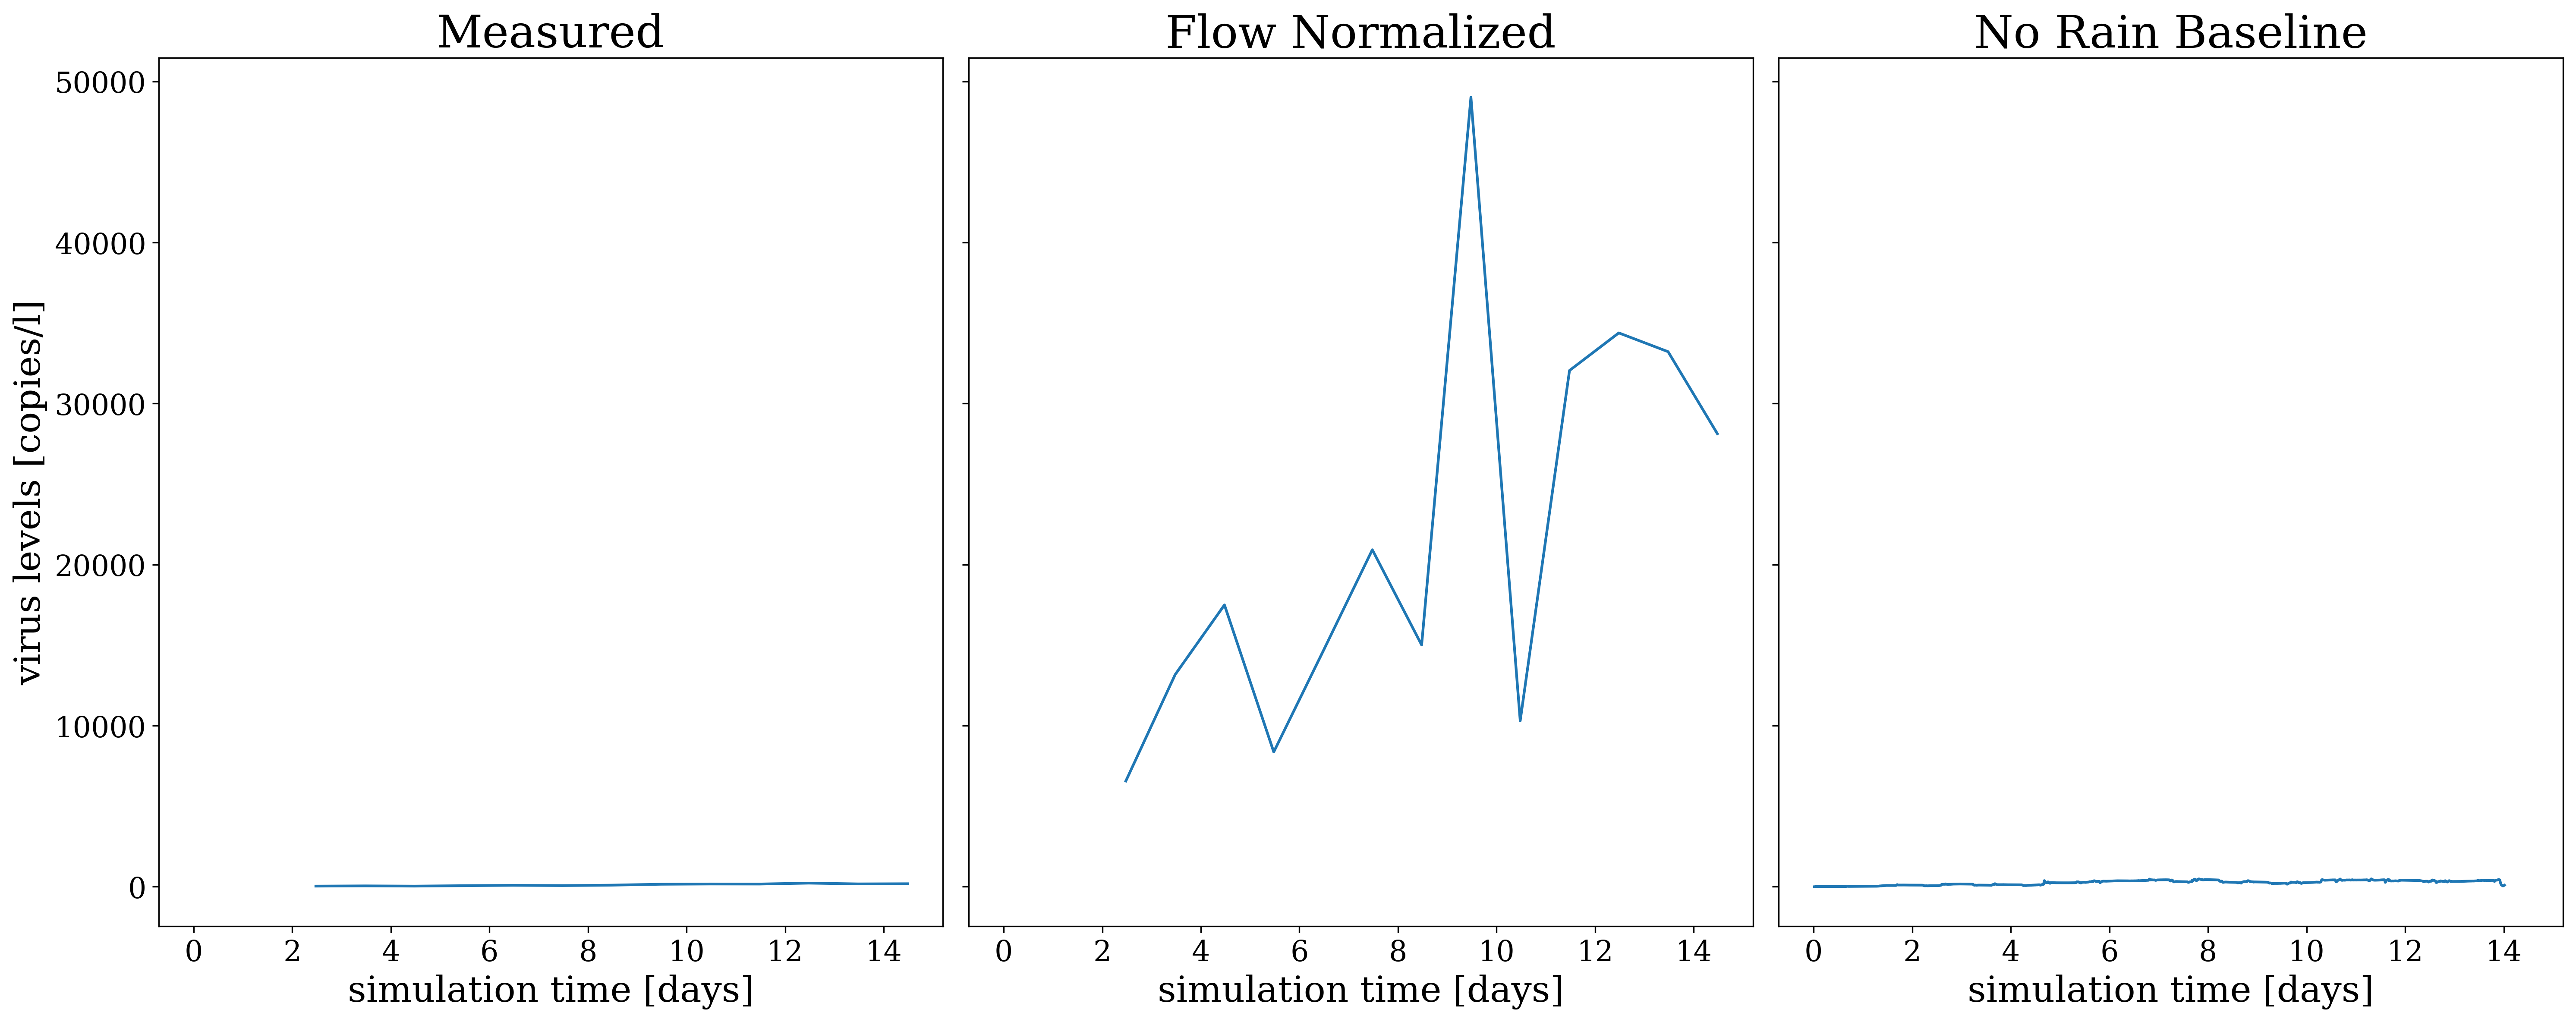

In [216]:
memilio_id = 2

df_concentration_agg = df_concentration_agg.loc[df_concentration_agg.memilio_id==memilio_id, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

date_form = DateFormatter("%-d")

fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(20, 8), dpi=300)

sns.lineplot(df_concentration_agg, x="time", y="copies/l", ax=axs[0])
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("virus levels [copies/l]", fontsize=20)
sns.lineplot(df_concentration_agg, x="time", y="flow_normalized_copies/l", ax=axs[1])
axs[1].set_ylabel("normalized virus levels [copies/l]", fontsize=20)
axs[1].set_title("Flow Normalized", fontsize=25)    
sns.lineplot(df_concentration_no_rain_sub, x="time", y="copies/l", ax=axs[2])
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("virus levels [copies/l]", fontsize=20)

for i in range(3):
    axs[i].xaxis.set_major_formatter(date_form) 
    axs[i].set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()

#### Visualization of Normalization

/tmp/ipykernel_234459/3256132982.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_234459/3256132982.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_234459/3256132982.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


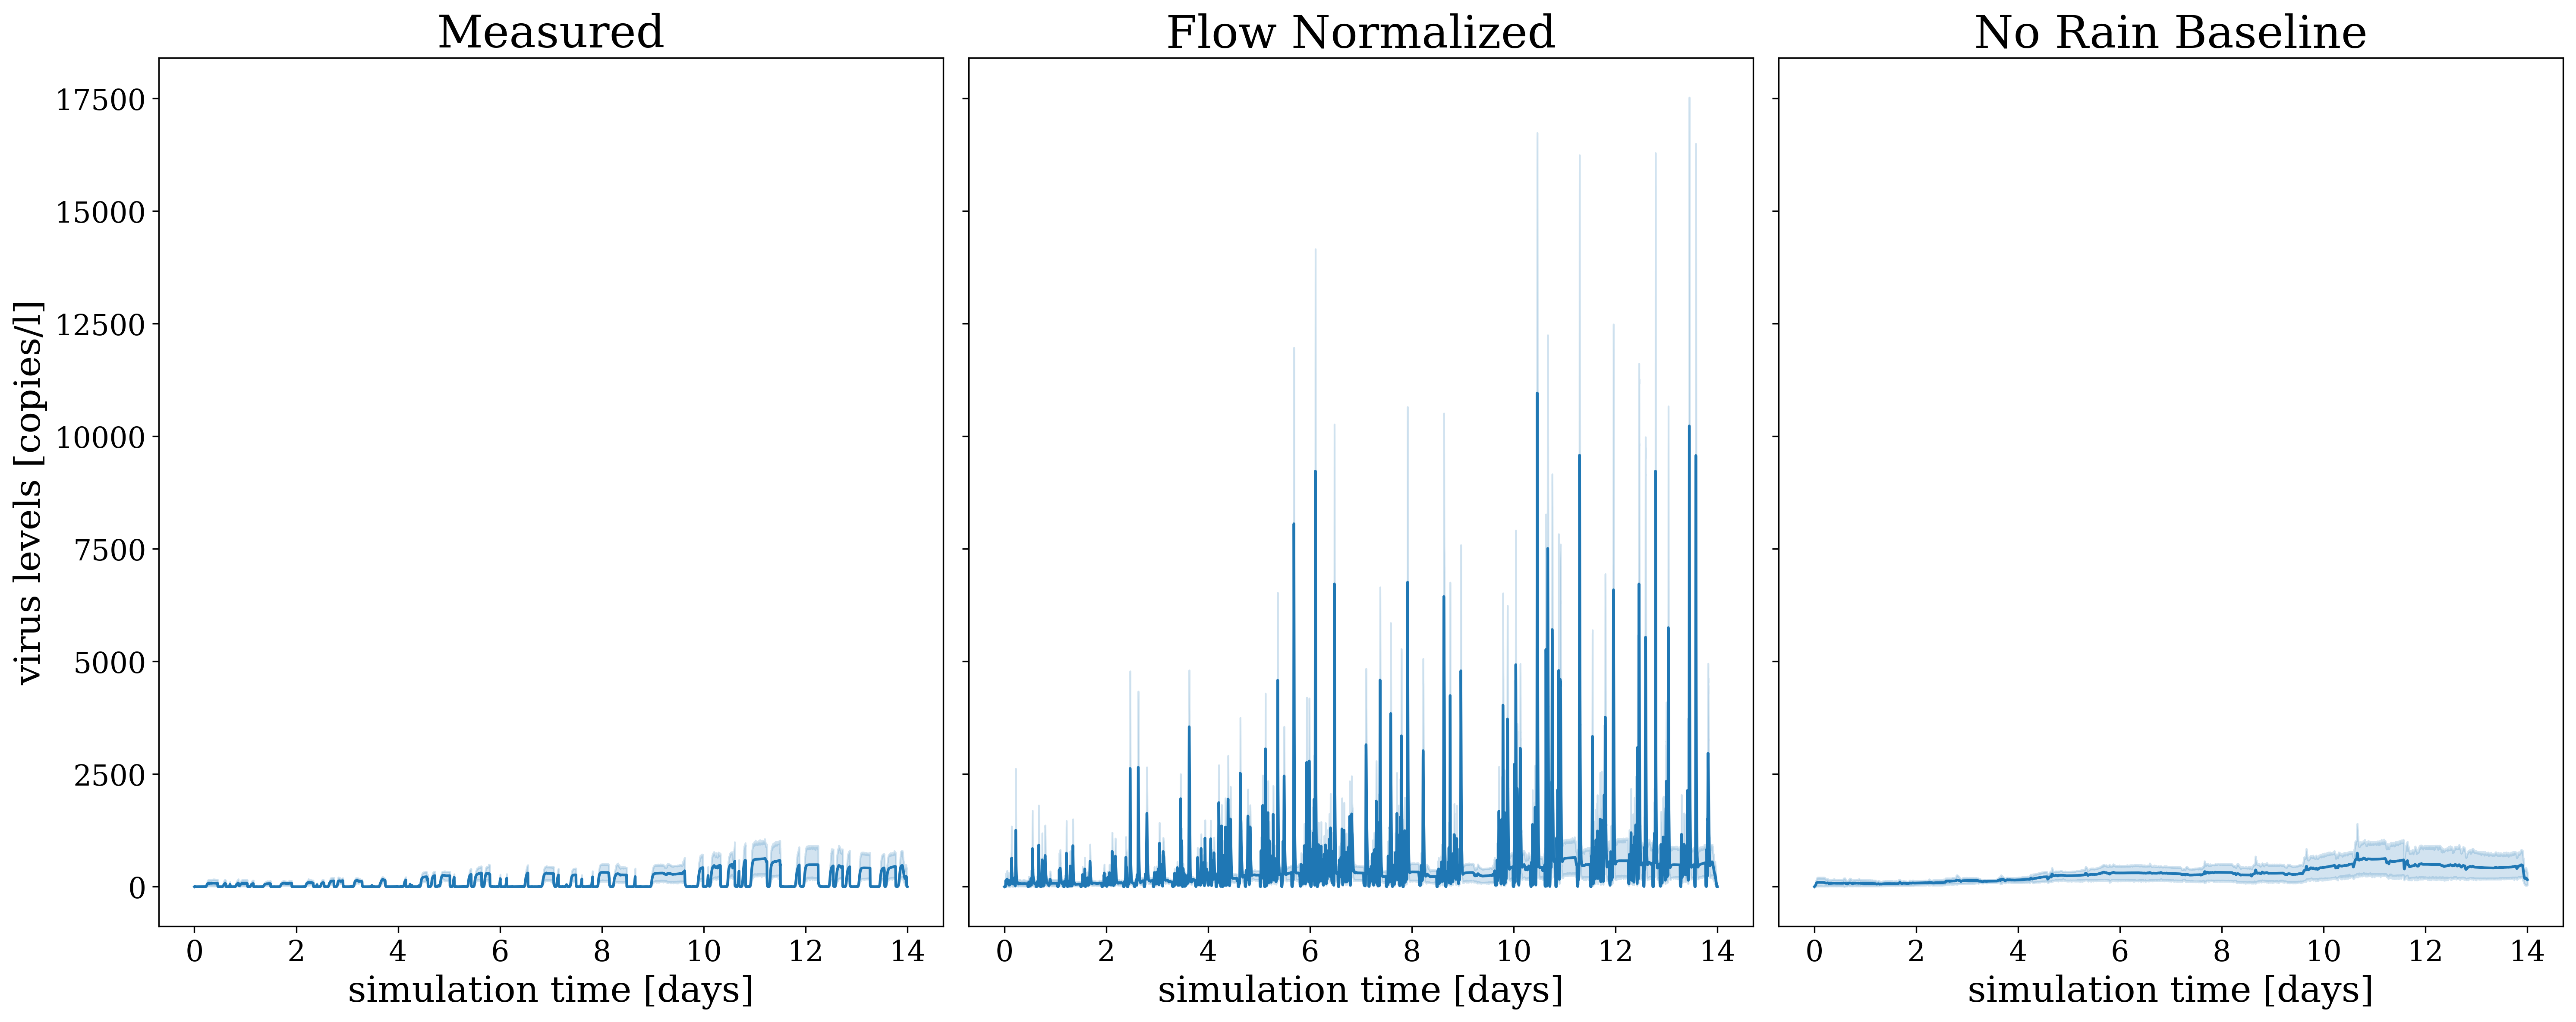

In [36]:
date_form = DateFormatter("%-d")

fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(20, 8), dpi=300)

sns.lineplot(df_concentration, x="time", y="copies/l", ax=axs[0])
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("virus levels [copies/l]", fontsize=20)
sns.lineplot(df_concentration, x="time", y="flow_normalized_copies/l", ax=axs[1])
axs[1].set_ylabel("normalized virus levels [copies/l]", fontsize=20)
axs[1].set_title("Flow Normalized", fontsize=25)    
sns.lineplot(df_concentration_no_rain, x="time", y="copies/l", ax=axs[2])
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("virus levels [copies/l]", fontsize=20)

for i in range(3):
    axs[i].xaxis.set_major_formatter(date_form) 
    axs[i].set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"overview_{substance}_{rain_scenario}_{degradation_setting}_{sampling_point}.png"))

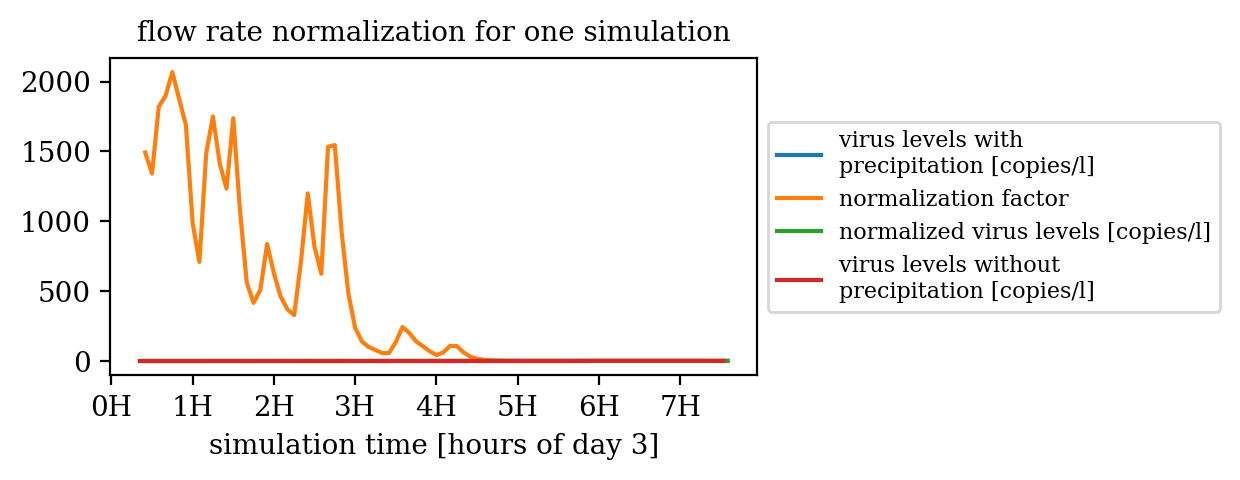

In [161]:
simulation_id = 5

df_concentration['minutes'] = (df_concentration['time'] - df_concentration['time'].min()).dt.total_seconds() // 60
df_concentration_no_rain['minutes'] = (df_concentration_no_rain['time'] - df_concentration_no_rain['time'].min()).dt.total_seconds() // 60

df_sub = df_concentration.loc[df_concentration.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]

fig, axs = plt.subplots(figsize=(6.3,2.5), dpi=200)
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels with\nprecipitation [copies/l]")
plt.plot(df_sub_sub["time"], df_sub_sub["flow_normalization_factor"], label="normalization factor")
plt.plot(df_sub_sub["time"], df_sub_sub["flow_normalized_copies/l"], label="normalized virus levels [copies/l]")

df_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels without\nprecipitation [copies/l]")
date_form_2 = DateFormatter("%-HH")
axs.xaxis.set_major_formatter(date_form_2) 
axs.set_xlabel(f"simulation time [hours of day 3]", fontsize=10) # , fontsize=15
# axs.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.title("flow rate normalization for one simulation", fontsize=10)
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"examplary_{substance}_{rain_scenario}_{degradation_setting}_{sampling_point}_simulation_{simulation_id}.png"))